In [7]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from config import *
from utils.load_data import load_distributional_dataset
from models.gaussian_forward import GaussianForwardModel

# === setup device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === choose trial number to revisit ===
trial = 9  # change this to revisit old checkpoints
is_old_trial = trial < TRIAL_GAUSSIAN

# === define dimensions for old trials ===
s_dim_old = 4
p_dim_old = 9
hidden_dims_old = [64]
model_path_old = f"checkpoints/gaussian/gaussian_ckpt_{trial}.pt"

# === dynamically configure model ===
if is_old_trial:
    s_dim = s_dim_old
    p_dim = p_dim_old
    hidden_dims = hidden_dims_old
    model_path = model_path_old
else:
    s_dim = S_DIM
    p_dim = P_DIM
    hidden_dims = HIDDEN_DIMS
    model_path = GAUSSIAN_SAVE_PATH

# === load model ===
model = GaussianForwardModel(s_dim, p_dim, hidden_dims=hidden_dims).to(device)
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()
print("\n✅ Gaussian Forward Model Loaded:\n", model)


✅ Gaussian Forward Model Loaded:
 GaussianForwardModel(
  (backbone): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): Tanh()
  )
  (mu): Linear(in_features=64, out_features=9, bias=True)
  (log_sigma): Linear(in_features=64, out_features=9, bias=True)
)


/var/folders/9z/9fdpt4_148s8zzl9h0tr9dgw0000gn/T/ipykernel_25615/3521508139.py:35: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

In [14]:
# === load empirical distributional dataset ===
empirical_data = load_distributional_dataset(DISTRIBUTIONAL_DATA_PATH)
S_keys = list(empirical_data.keys())
print(f"✅ Loaded {len(S_keys)} unique S values.")

# === pick a structure S to analyze ===
S_val = np.array(S_keys[0])  # or change index to try others
P_true_samples = empirical_data[S_keys[0]]  # shape: (num_samples, 9)
print(f"✅ Empirical P samples for S={S_val}: shape {P_true_samples.shape}")

✅ Loaded 30 unique S values.
✅ Empirical P samples for S=[39.38301 34.08085  0.       0.644  ]: shape (100, 9)


In [21]:
# === convert S to torch tensor for model ===
S_val_torch = torch.tensor(S_val, dtype=torch.float32).unsqueeze(0).to(device)

# === prediction and sampling function ===
def get_P_predictions(S_val_torch, num_samples=100):
    S_tensor = S_val_torch.repeat(num_samples, 1).to(device)
    with torch.no_grad():
        mu, log_sigma = model(S_tensor)
        sigma = torch.exp(log_sigma)
        eps = torch.randn_like(mu)
        P_samples = mu + sigma * eps
    return mu[0].cpu().numpy(), sigma[0].cpu().numpy(), P_samples.cpu().numpy()

# === get predicted P samples ===
mu_pred, sigma_pred, P_hats = get_P_predictions(S_val_torch, num_samples=100)

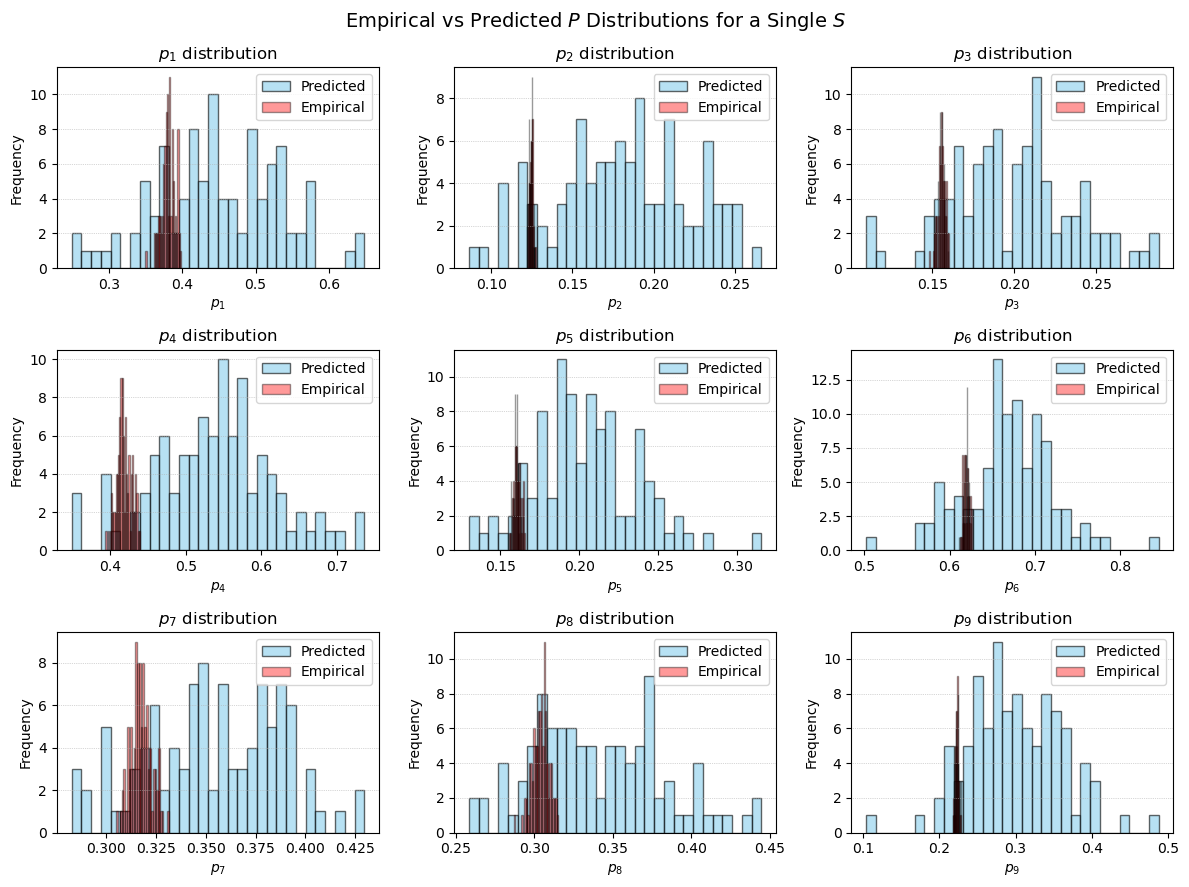

In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 3, figsize=(12, 9))
axs = axs.flatten()

for i in range(9):
    # plot predicted
    axs[i].hist(P_hats[:, i], bins=30, color='skyblue', edgecolor='black', alpha=0.6, label='Predicted')
    # plot empirical
    axs[i].hist(P_true_samples[:, i], bins=30, color='red', edgecolor='black', alpha=0.4, label='Empirical')
    axs[i].set_title(f"$p_{{{i+1}}}$ distribution")
    axs[i].set_xlabel(f"$p_{{{i+1}}}$")
    axs[i].set_ylabel("Frequency")
    axs[i].legend()
    axs[i].grid(True, axis='y', linestyle=':', linewidth=0.5)

fig.suptitle(f"Empirical vs Predicted $P$ Distributions for a Single $S$", fontsize=14)
plt.tight_layout()
plt.show()

In [27]:
import numpy as np
from scipy.stats import entropy

print(f"{'P':<3} {'μ_emp':>8} {'μ_pred':>8} {'σ_emp':>8} {'σ_pred':>8} {'Δμ':>7} {'σ*/σ':>7} {'KL':>8}")
print("-" * 65)
for i in range(9):
    emp = P_true_samples[:, i]
    pred = P_hats[:, i]
    # Means and stds
    mu_emp, mu_pred = np.mean(emp), np.mean(pred)
    std_emp, std_pred = np.std(emp), np.std(pred)
    # KL divergence (empirical, using histograms)
    bins = np.histogram_bin_edges(np.concatenate([emp, pred]), bins=30)
    emp_hist, _ = np.histogram(emp, bins=bins, density=True)
    pred_hist, _ = np.histogram(pred, bins=bins, density=True)
    # Add small value to avoid log(0)
    emp_hist += 1e-10
    pred_hist += 1e-10
    kl = entropy(emp_hist, pred_hist)
    # Print condensed row
    print(f"p{i+1:<2} {mu_emp:8.3f} {mu_pred:8.3f} {std_emp:8.3f} {std_pred:8.3f} {mu_pred-mu_emp:7.3f} {std_pred/std_emp if std_emp>0 else float('inf'):7.2f} {kl:8.3f}")

P      μ_emp   μ_pred    σ_emp   σ_pred      Δμ    σ*/σ       KL
-----------------------------------------------------------------
p1     0.380    0.450    0.009    0.084   0.069    9.21    2.177
p2     0.124    0.181    0.001    0.041   0.056   37.92    3.398
p3     0.155    0.199    0.002    0.037   0.043   17.43    2.593
p4     0.418    0.537    0.010    0.080   0.119    8.26   13.769
p5     0.161    0.203    0.002    0.033   0.043   15.26    2.872
p6     0.620    0.668    0.003    0.052   0.049   16.65    3.021
p7     0.318    0.353    0.005    0.034   0.036    6.44    2.025
p8     0.304    0.340    0.005    0.041   0.036    8.00    1.508
p9     0.223    0.299    0.002    0.061   0.076   27.06    3.318
